In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/DeepLearning/final_project/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from data_utils.elastic_deformation import *
from data_utils.evaluation import *

In [4]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from scipy import ndimage

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
import cv2
import pandas as pd

#data augmentation
!pip install elasticdeform
import imageio, elasticdeform


In [5]:
grade = pd.read_csv('warwick_data/Grade.csv')
#grade.loc['name'].startswith('testA')
print('number of testA images: ',len(grade.loc[(grade['name'].str.startswith('testA_'))]))
print('number of testB images: ',len(grade.loc[(grade['name'].str.startswith('testB_'))]))
print('number of train images: ',len(grade.loc[(grade['name'].str.startswith('train_'))]))
grade.sample(5)


number of testA images:  60
number of testB images:  20
number of train images:  85


name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)
141  train_65           1        benign                           adenomatous
39   testA_45          12     malignant             moderately differentiated
138  train_62           9        benign                               healthy
46   testA_51           7     malignant             moderately differentiated
97   train_25          10        benign                               healthy

In [0]:
def label_cat (row):
  if row['name'].startswith('testA_') :
    return 'testA'
  elif row['name'].startswith('testB_') :
    return 'testB'
  elif row['name'].startswith('train'):
    return 'train'
  else:
    return 'Other'

In [0]:
grade['name_label'] = grade.apply (lambda row: label_cat(row), axis=1)


In [8]:
grade.columns

Index(['name', 'patient ID', ' grade (GlaS)',
       ' grade (Sirinukunwattana et al. 2015)', 'name_label'],
      dtype='object')

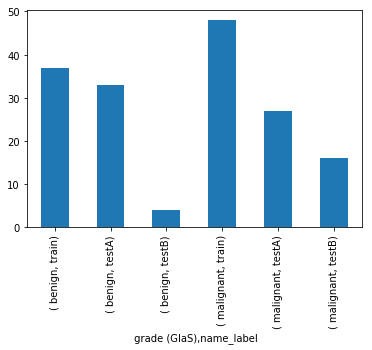

In [9]:
grade['name_label'].groupby(grade[' grade (GlaS)']).value_counts().plot(kind='bar');

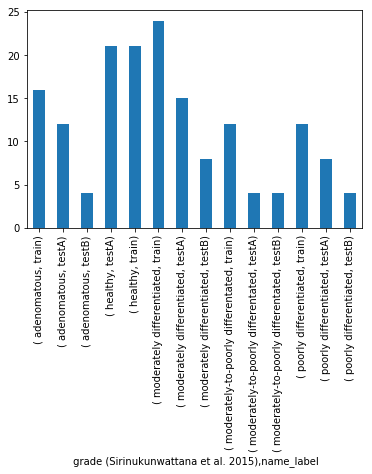

In [10]:
grade['name_label'].groupby(grade[' grade (Sirinukunwattana et al. 2015)']).value_counts().plot(kind='bar');

# Loading the data
TODO:
  * We need to make sure that the data is loaded correctly, since there are different names
    * Test A
    * Test B
    * Train 
    
    Maybe we could ask Peter about that...
  * Increase size to original size and test if we can get better results
  * add another channel for the boundaries of the cells

In [0]:

images = []
masks = []
size=(256,256) # original size is 576x576 -> maybe increas it for later tests
for root, dirs, files in os.walk('warwick_data/'):
   for f in files:
      if not f.endswith('anno.bmp') and not f.endswith('csv'):
        img_path = f
        images.append(resize(imread(os.path.join(root, img_path)), size, mode='constant',anti_aliasing=True))
        
        mask_path = f[:-4]+'_anno.bmp'
        masks.append(resize(imread(os.path.join(root, mask_path)), size, mode='constant',anti_aliasing=True)>0)


## Segment masks in individual cells
  + search for different values in the cells

In [48]:
masks[0].max()

True

In [49]:
X = np.array(images, np.float32)
Y = np.array(masks, np.float32)
print('Loaded %d images' % len(X))
print('Loaded %d masks' % len(Y))


Loaded 165 images
Loaded 165 masks


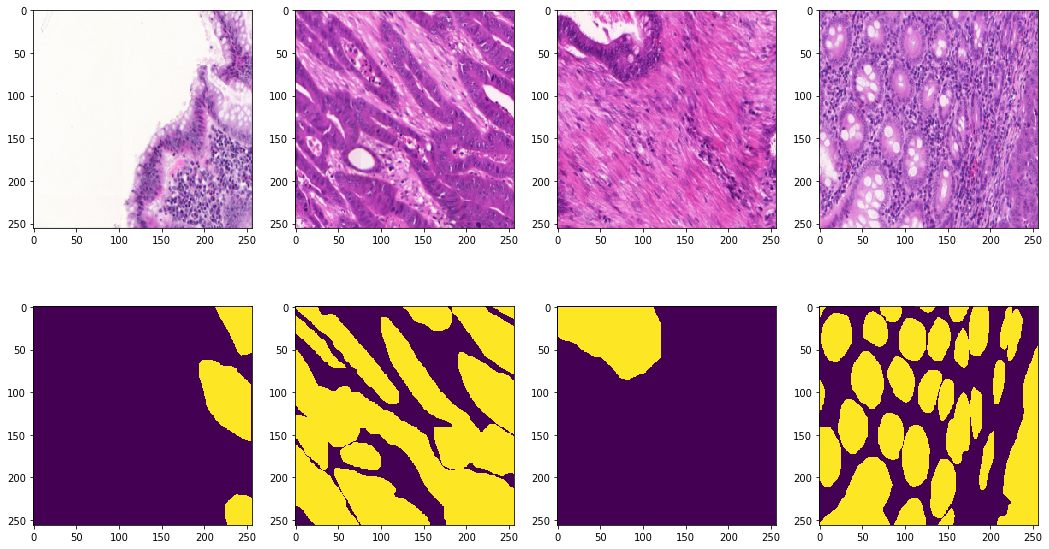

In [50]:

plt.rcParams['figure.figsize'] = [18, 10]

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(X[i])

    plt.subplot(2, 4, i+5)
    plt.imshow(Y[i])


plt.show();

# Data augmentation
  + horizontal flip
  + vertical flip
  + elastic deformation (play with parameters)
  

In [51]:
data_aug_on = True
if data_aug_on:
  #vertical flip
  X=np.concatenate((X,np.flipud(X)))
  Y=np.concatenate((Y,np.flipud(Y)))

  #horizontal flip
  X=np.concatenate((X,np.fliplr(X)))
  Y=np.concatenate((Y,np.fliplr(Y)))


  print('Loaded %d images' % len(X))
  print('Loaded %d masks' % len(Y))

Loaded 660 images
Loaded 660 masks


## Test: elastic deformation

In [0]:
def elastic_deform(X,Y,sigma=25,points=2):
  X_deformed = []
  Y_deformed = []

  for i in range(len(X)):
    [X_def_temp, Y_def_temp] = elasticdeform.deform_random_grid([X[i],Y[i]], axis=[(0, 1), (0, 1)],sigma=sigma,points=points)
    X_deformed.append(X_def_temp/X_def_temp.max())
    Y_deformed.append((Y_def_temp/Y_def_temp.max())>0.2) # uncomment if masks are not binary
    #Y_deformed.append(Y_def_temp)
    
  return np.array(X_deformed, np.float32),np.array(Y_deformed, np.float32)
  

In [0]:
X_deformed1,Y_deformed1 = elastic_deform(X,Y,sigma=15,points=2)
X_deformed2,Y_deformed2 = elastic_deform(X,Y,sigma=25,points=3)
X=np.concatenate((X,X_deformed1))
Y=np.concatenate((Y,Y_deformed1))
X=np.concatenate((X,X_deformed2))
Y=np.concatenate((Y,Y_deformed2))

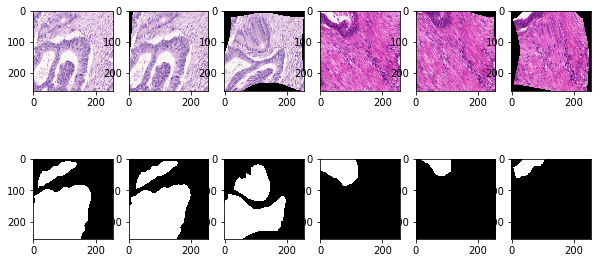

In [54]:
no=5
no2=2

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,6,1)
plt.imshow(X[no])


ax2 = plt.subplot(2,6,7)
plt.imshow(Y[no],cmap='gray')

ax3 = plt.subplot(2,6,2)
plt.imshow(X_deformed1[no])


ax4 = plt.subplot(2,6,8)
plt.imshow(Y_deformed1[no],cmap='gray')
ax5 = plt.subplot(2,6,3)
plt.imshow(X_deformed2[no])


ax6 = plt.subplot(2,6,9)
plt.imshow(Y_deformed2[no],cmap='gray')

ax7 = plt.subplot(2,6,4)
plt.imshow(X[no2])


ax8 = plt.subplot(2,6,10)
plt.imshow(Y[no2],cmap='gray')

ax9 = plt.subplot(2,6,5)
plt.imshow(X_deformed1[no2])


ax10 = plt.subplot(2,6,11)
plt.imshow(Y_deformed1[no2],cmap='gray')
ax11 = plt.subplot(2,6,6)
plt.imshow(X_deformed2[no2])


ax12 = plt.subplot(2,6,12)
plt.imshow(Y_deformed2[no2],cmap='gray')


1.0


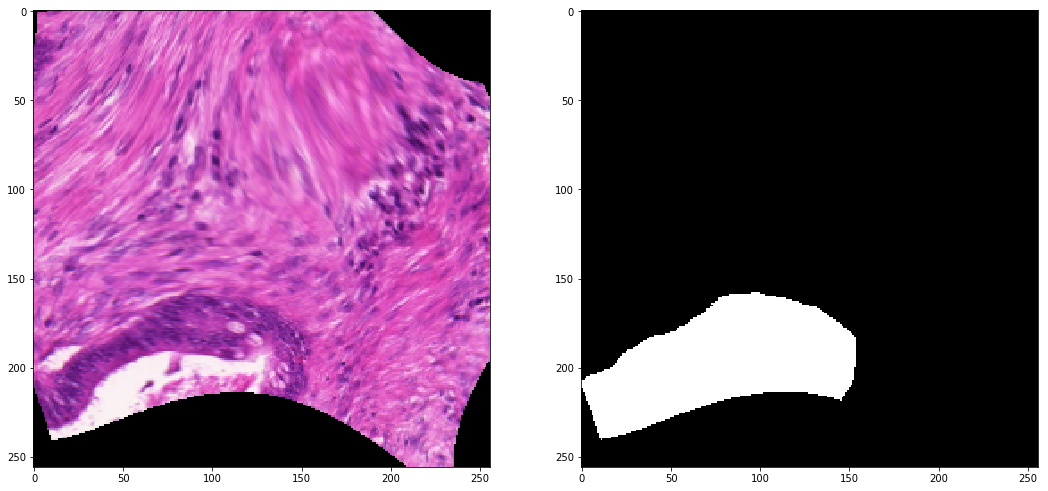

In [46]:
no=-3
plt.subplot(1,2,1)
plt.imshow(X[no])

plt.subplot(1,2,2)

plt.imshow(Y[no]/Y[no].max()>0.2,cmap='gray')
print((Y[no]/Y[no].max()).max())

In [0]:
ix = np.random.choice(len(X), len(X), False)
#print(ix)
tr, val = np.split(ix, [int(len(X)/4*3)]) # set better values

In [56]:
print(len(tr), len(val))

1485 495


In [0]:
batch_size = 12
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=False)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [59]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


TODO:
  + add multiple layer to each level (not only one)

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        #print(x.size())
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        #print(x.size())

        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(torch.cat([b,e3],1))))
        d1 = F.relu(self.dec_conv1(self.upsample1(torch.cat([d0,e2],1))))
        d2 = F.relu(self.dec_conv2(self.upsample2(torch.cat([d1,e1],1))))
        d3 = self.dec_conv3(self.upsample3(torch.cat([d2,e0],1)))

        return d3

In [0]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

## Training
TODO:
  + implement accuracy and validation loss like in the lecture
  + 

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)
        plt.rcParams['figure.figsize'] = [18, 6]
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [64]:
model = UNet().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
         Upsample-10          [-1, 128, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          73,792
         Upsample-12          [-1, 128, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          73,792
         Upsample-14        [-1, 128, 1

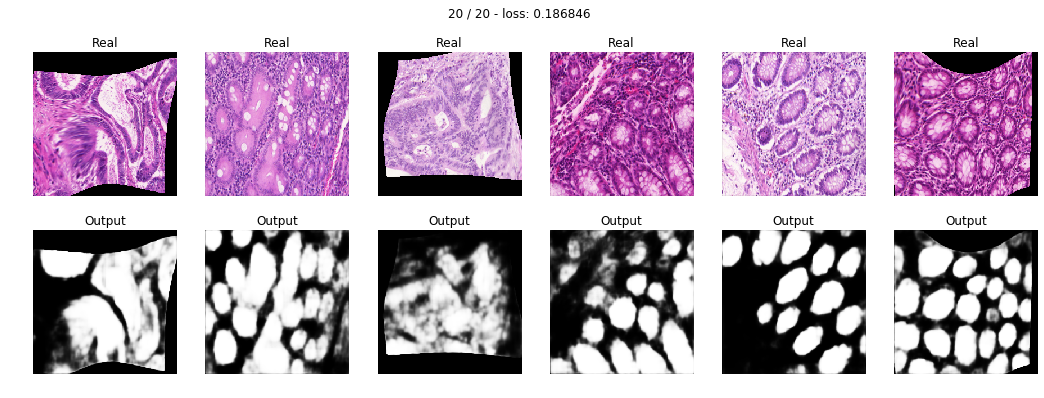

In [65]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

99


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


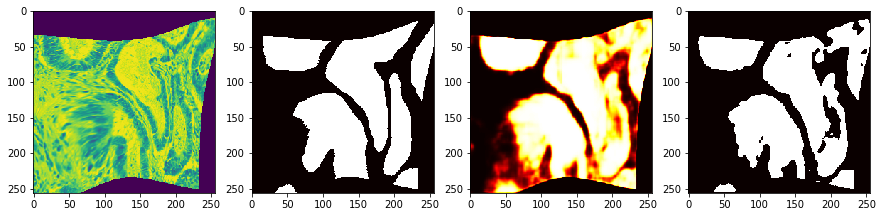

In [114]:
X_val, Y_val = next(iter(data_val))
X_val, Y_val = next(iter(data_val))

#X_val_seg, Y_val_seg = next(iter(data_val_seg))


model.eval()  # testing mode
Y_pred = torch.sigmoid(model(X_val.to(device))).detach().cpu()
Y_pred[0]

image,seg = ws(Y_pred,th=80)


fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(141)
plt.imshow(X_val[0, 0])


ax2 = plt.subplot(142)
plt.imshow(Y_val[0, 0], cmap='hot')

ax3 = plt.subplot(143)
plt.imshow(Y_pred[0, 0], cmap='hot')
ax4 = plt.subplot(144)
plt.imshow(image, cmap='hot')



th = 0.5
#compute TP
#compute FP
#compute FN

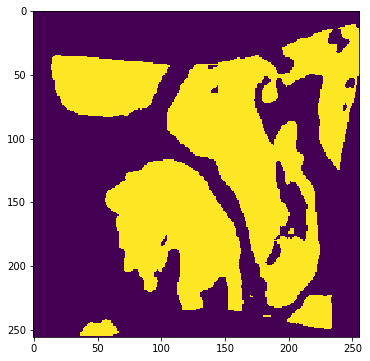

In [86]:
plt.imshow(Y_pred[0, 0]>0.8)

In [0]:
def ws(image_pred,th=80.0):
    image = (image_pred[0, 0].numpy()*100).astype(int)
    #print(image.max())
    # Make segmentation using edge-detection and watershed.
    edges = sobel(image)
    #plt.imshow(edges)
    # Identify some background and foreground pixels from the intensity values.
    # These pixels are used as seeds for watershed.
    markers = np.zeros_like(image)
    foreground, background = 1,2
    markers[image < th] = foreground
    markers[image >= th] = background
    
    #plt.imshow(markers)

    ws = watershed(edges, markers)
    seg1 = label(ws == foreground)

    # return the segmentations.
    return ws,seg1

# Watershed

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


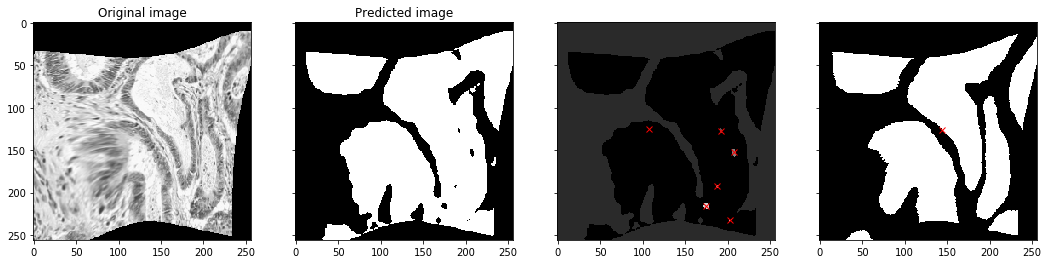

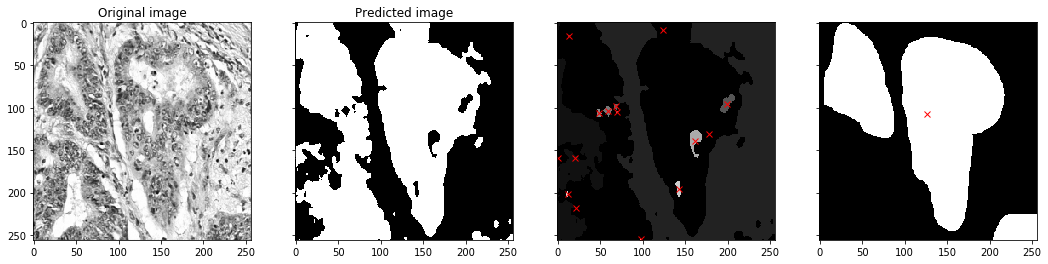

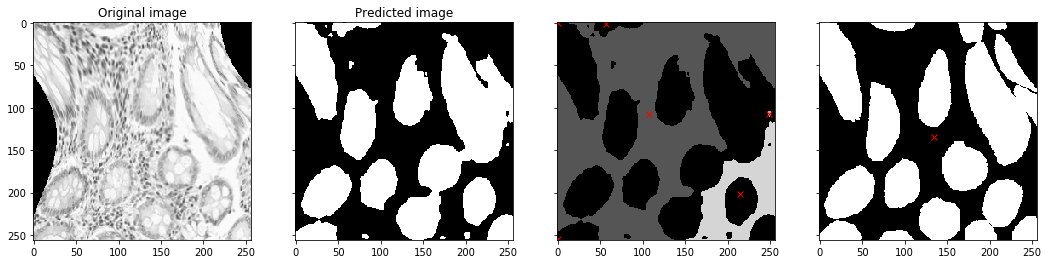

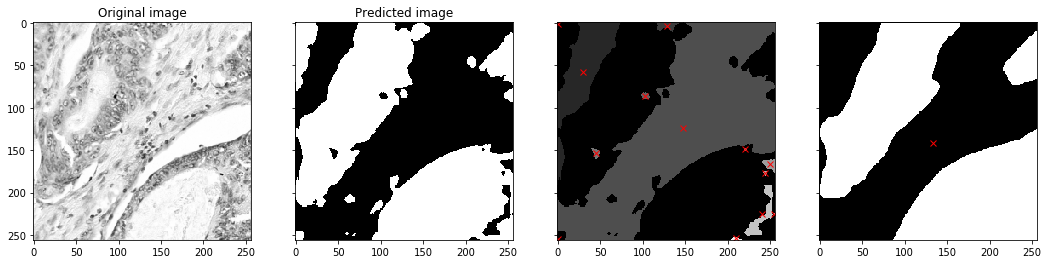

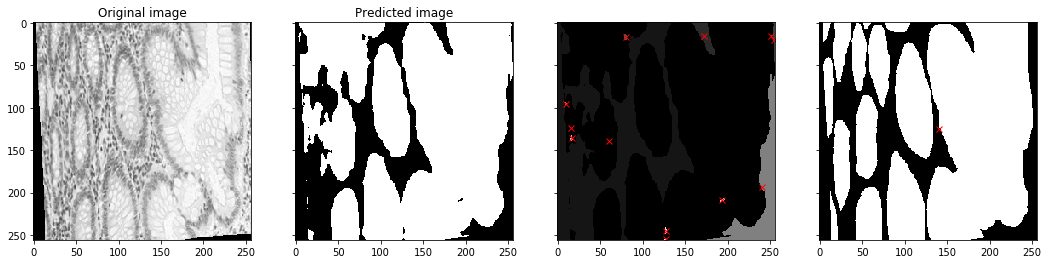

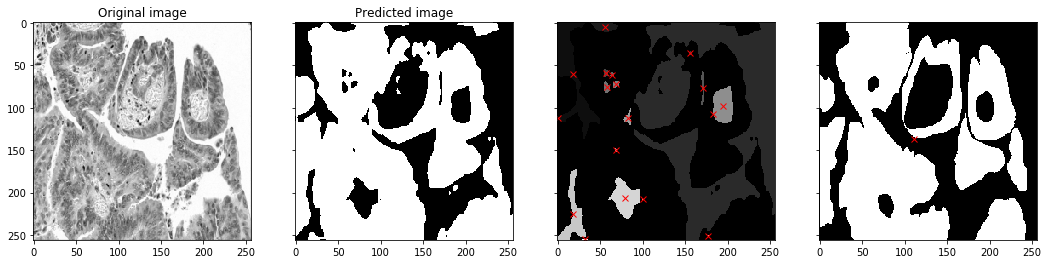

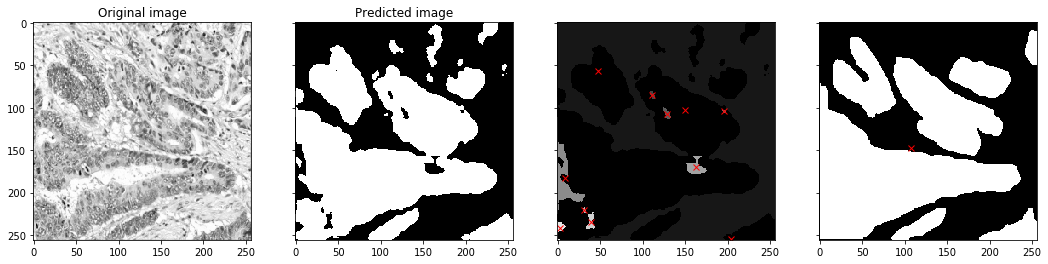

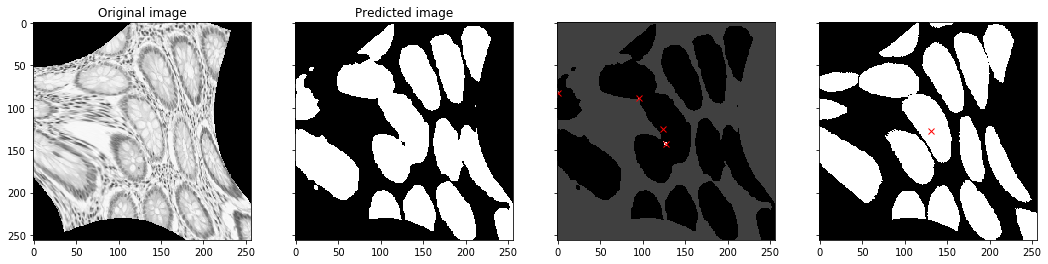

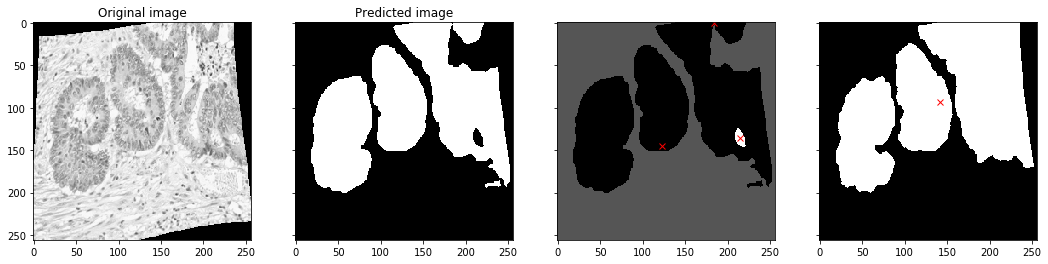

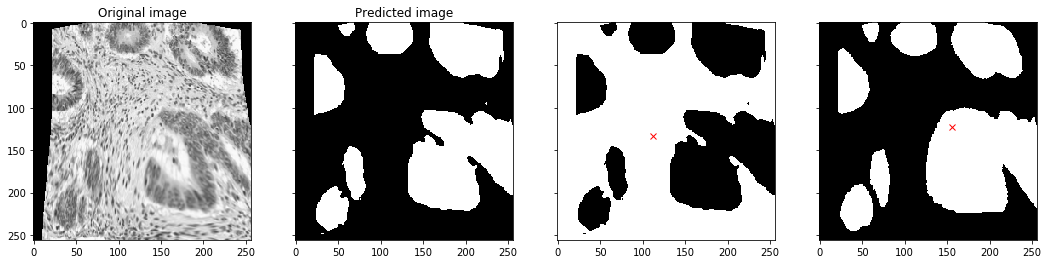

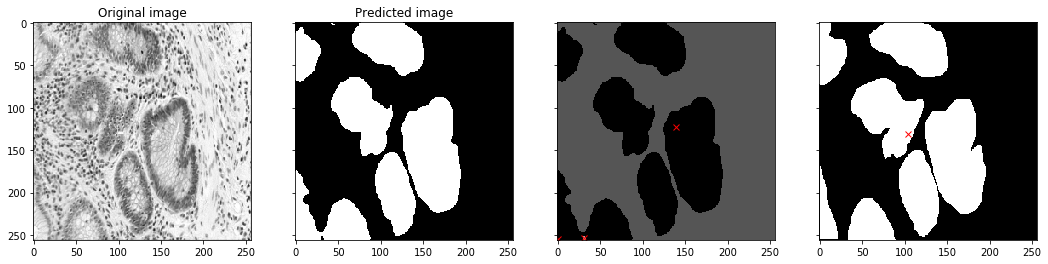

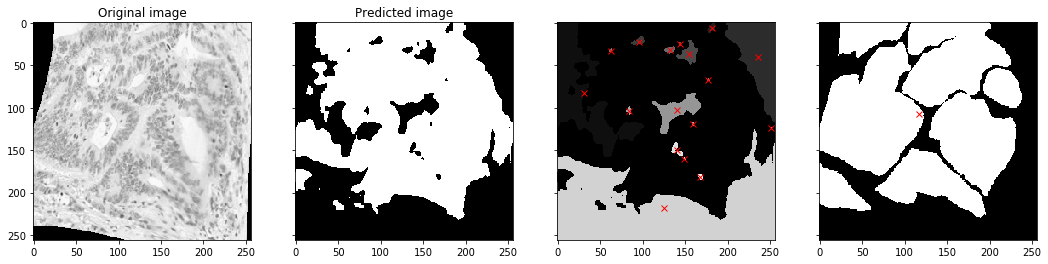

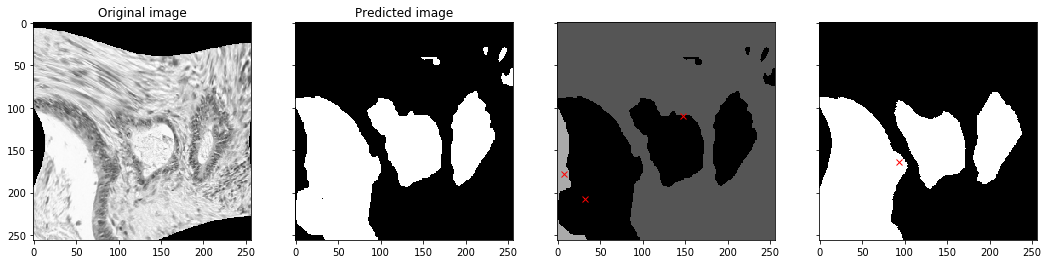

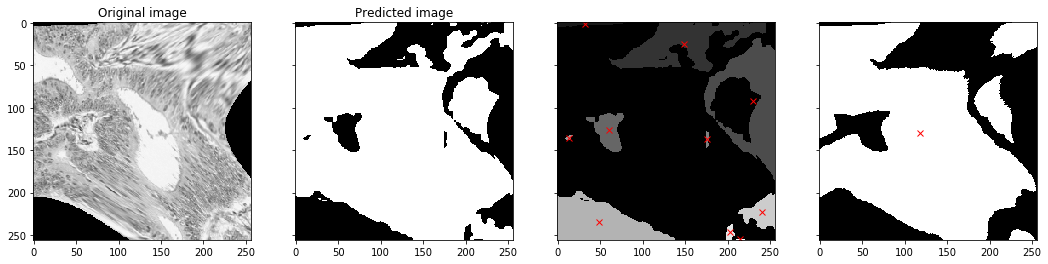

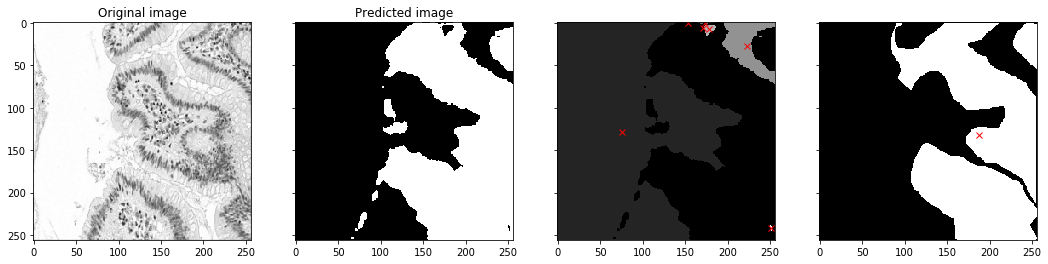

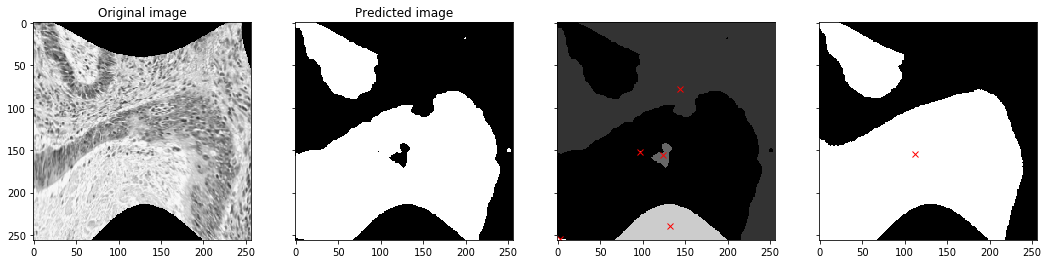

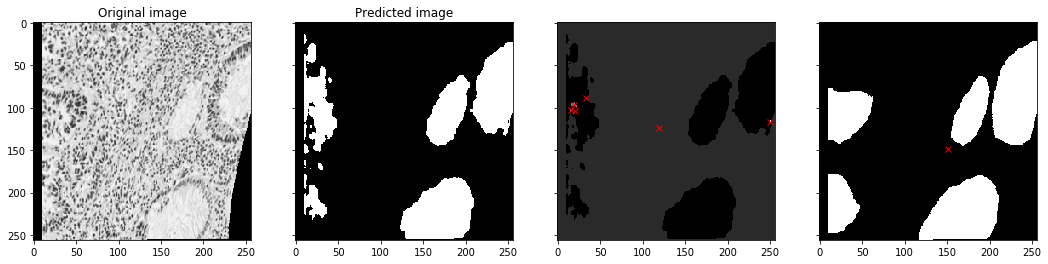

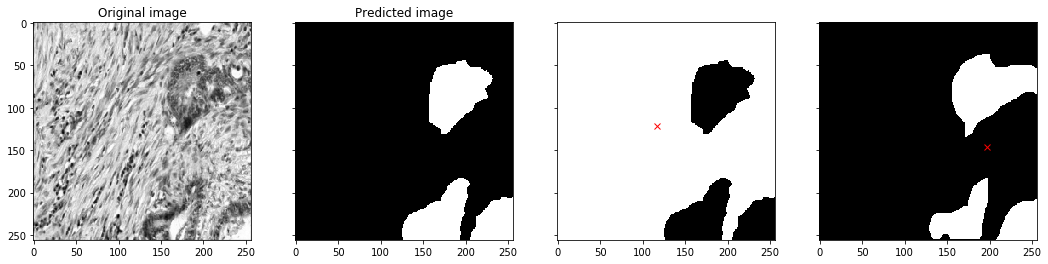

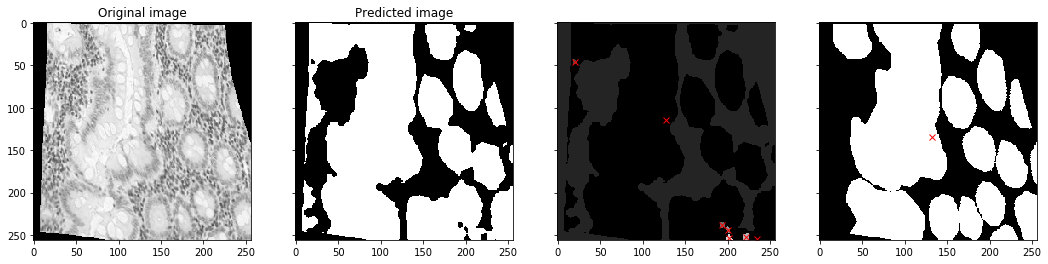

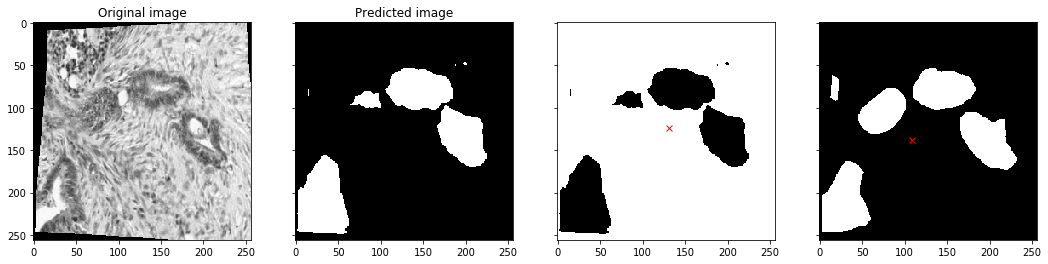

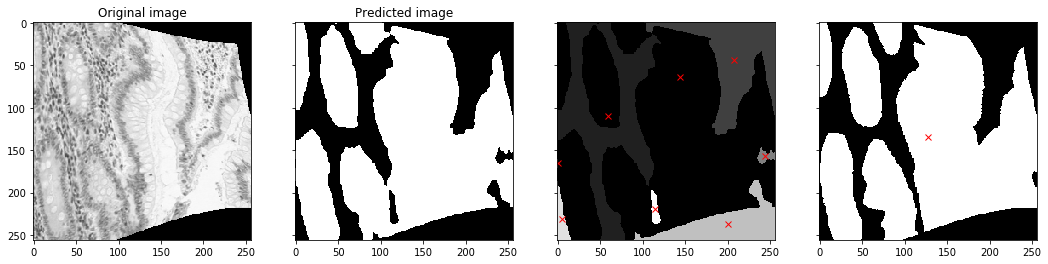

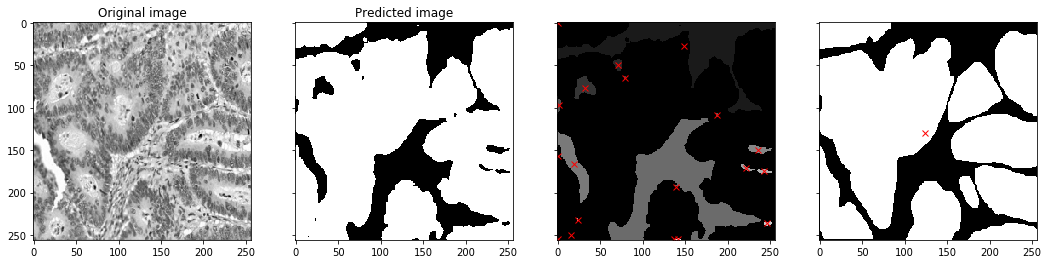

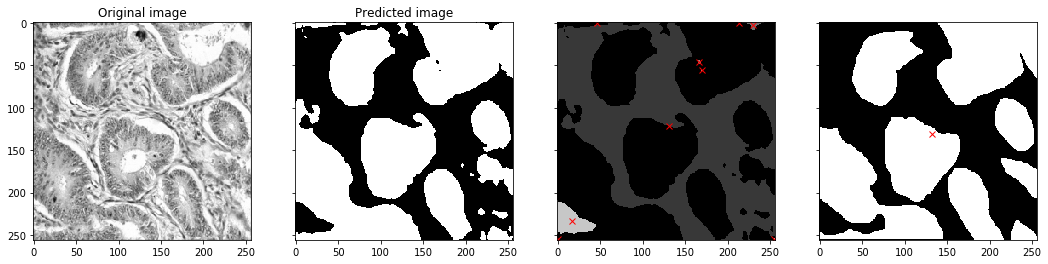

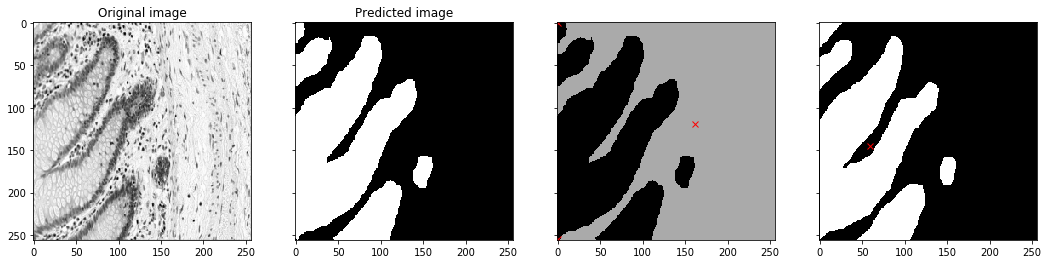

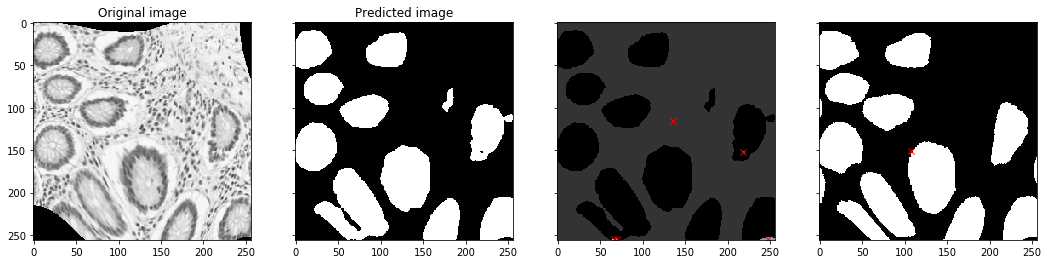

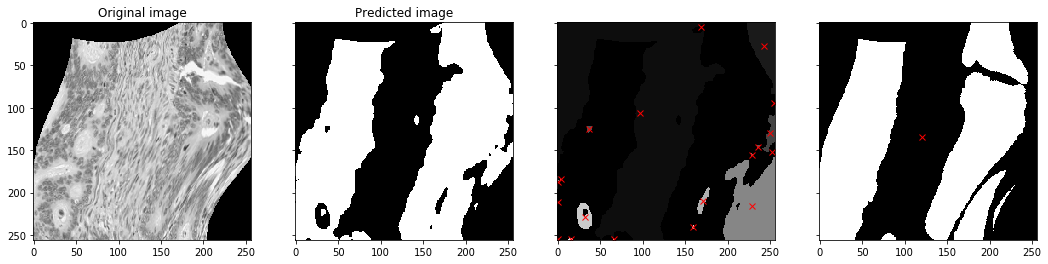

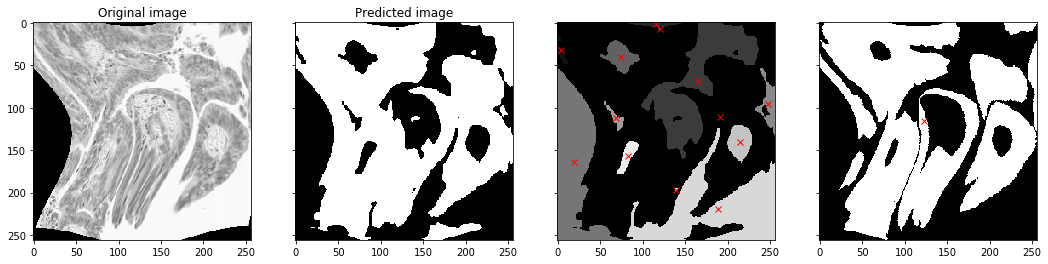

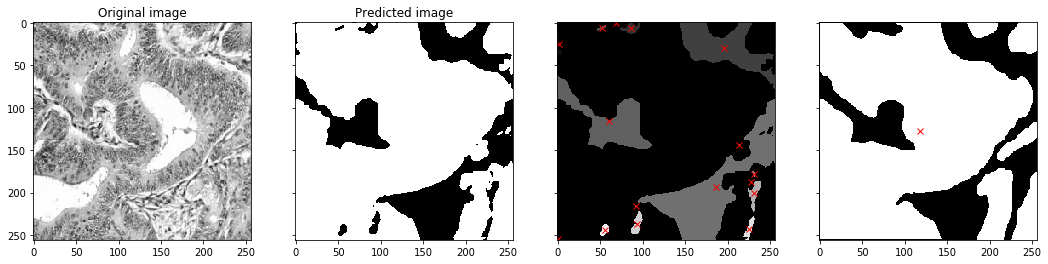

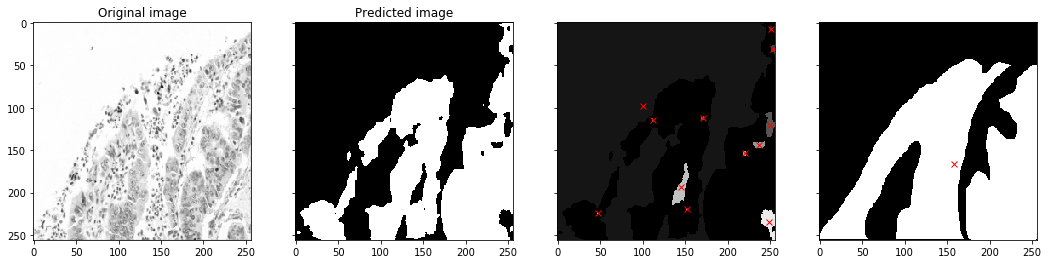

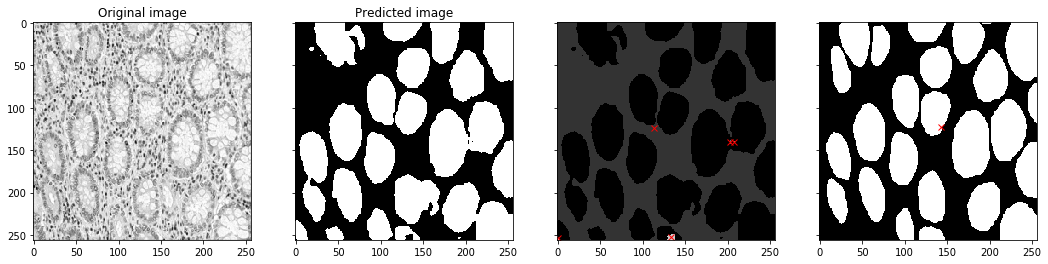

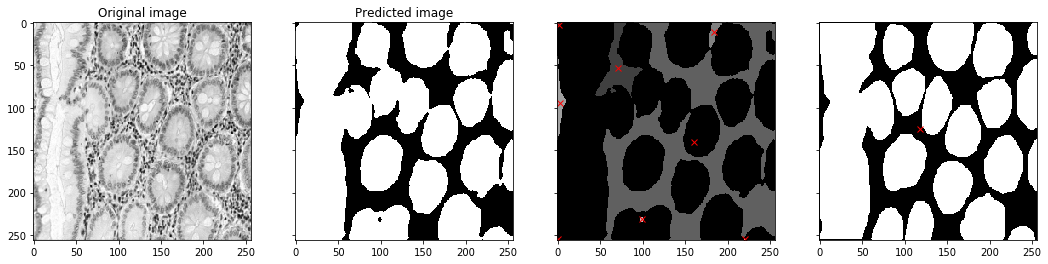

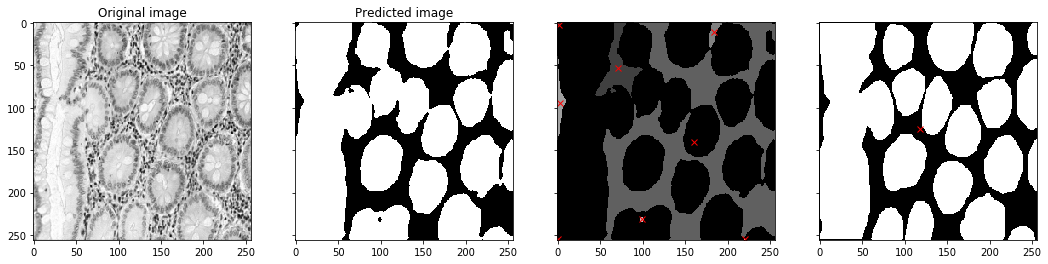

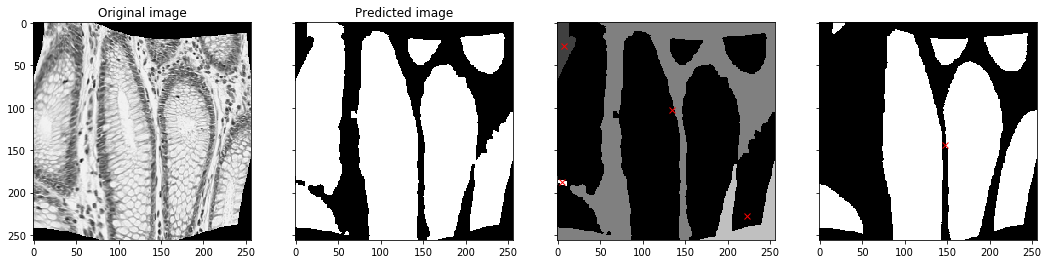

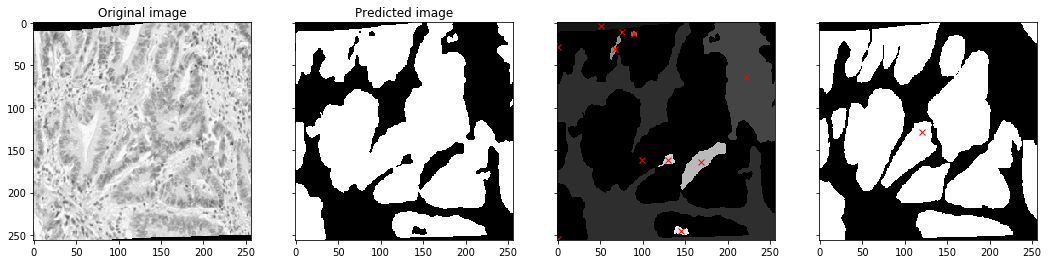

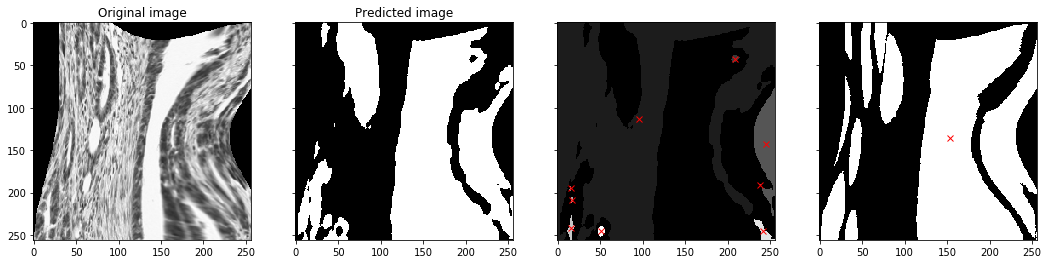

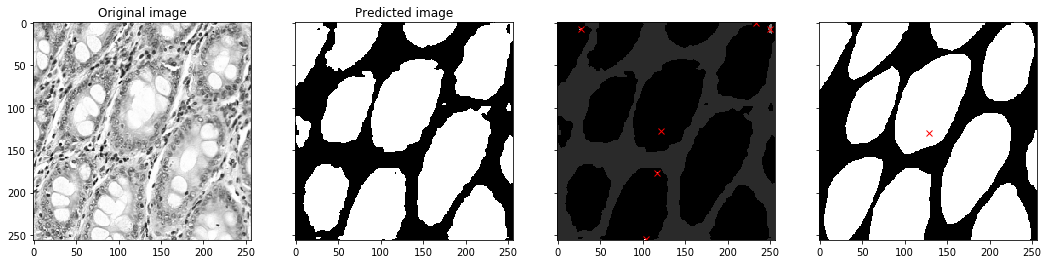

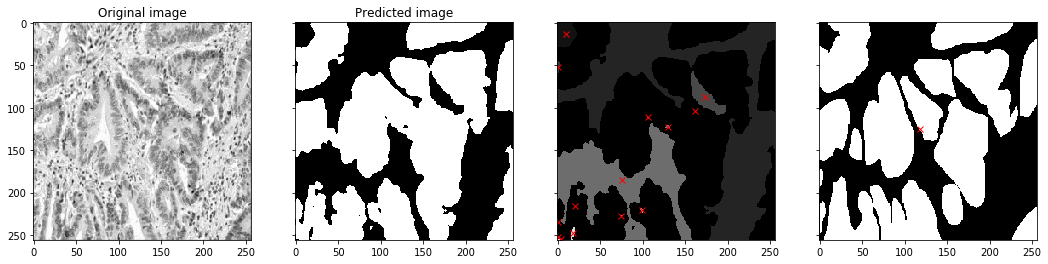

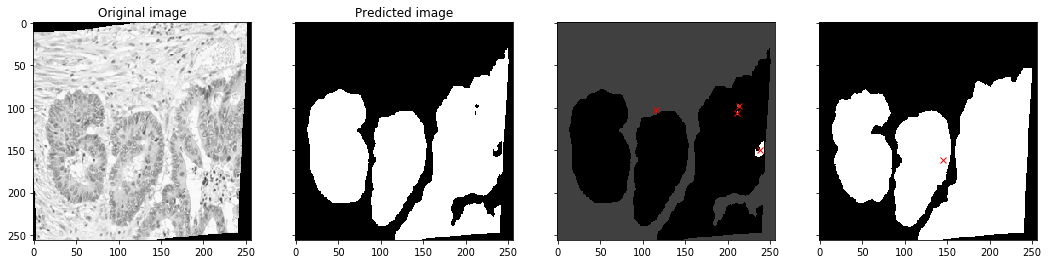

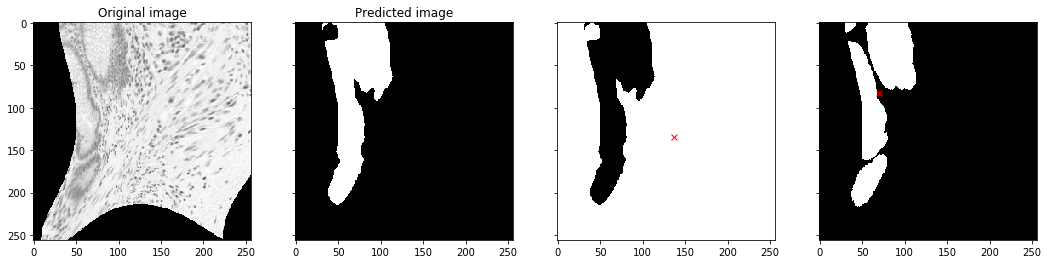

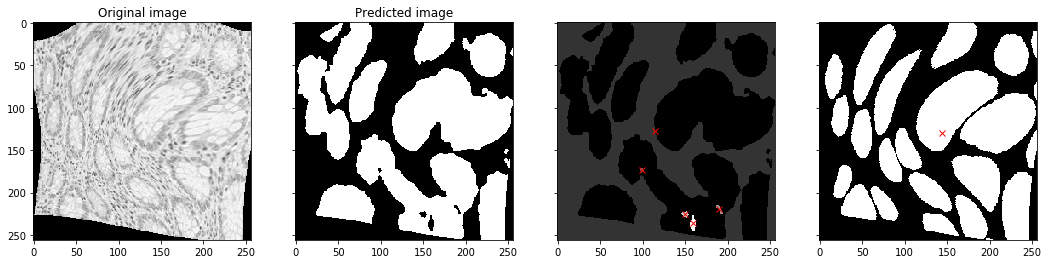

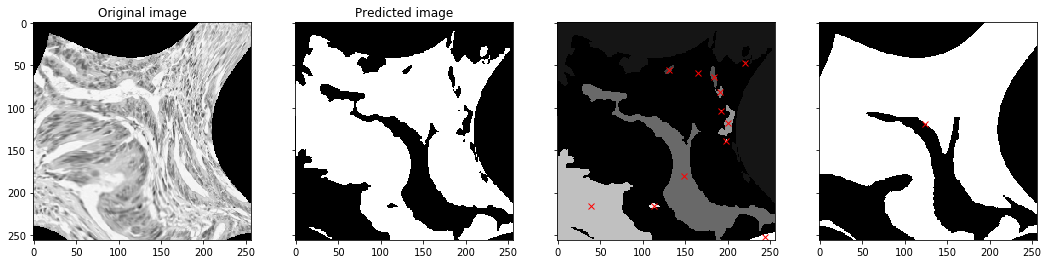

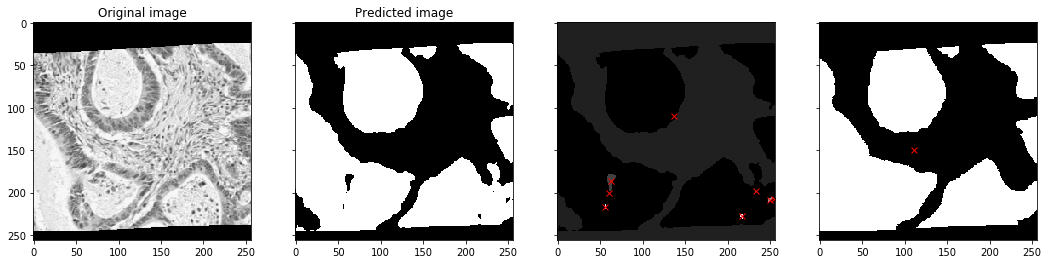

In [119]:
for X_val, Y_val in data_val:

    model.eval()  # testing mode
    Y_pred = F.sigmoid(model(X_val.to(device))).detach().cpu()
    image,seg = ws(Y_pred,th=40)
    com_pred = ndimage.measurements.center_of_mass(seg.astype(int), seg.astype(int), np.unique(seg)[1:])
    com_real  = ndimage.measurements.center_of_mass(Y_val[0,0].numpy().astype(int), Y_val[0,0].numpy().astype(int), np.unique(Y_val[0,0].numpy().astype(int))[1:])
    for idx,e  in enumerate(np.unique(seg)):
        seg[seg==e]=idx
    for idx,p in enumerate(com_pred):
        #get mask for predicted value
        mask_pred = seg.copy()
        mask_pred[mask_pred!=idx+1]=0

        cc_idx = closest_center(p,com_real)
        cc = com_real[cc_idx]
        mask_real =Y_val[0,0].numpy().astype(int) 
        mask_real[mask_real!=cc_idx+1]=0
    
    
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18, 4),
                         sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(X_val[0, 0].numpy(), cmap='gray')
    ax[0].set_title('Original image')
    
    ax[1].imshow(image, cmap='gray')
    ax[1].set_title('Predicted image')

    ax[2].imshow(seg,cmap='gray')
    #ax[2].set_title('Segemented prediction and center of mass')

    ax[2].plot(np.array(com_pred)[:,1],np.array(com_pred)[:,0],'rx')

    ax[3].imshow(Y_val[0,0],cmap='gray')
    #ax[3].set_title('Real Masks and center of mass')
    ax[3].plot(np.array(com_real)[:,1],np.array(com_real)[:,0],'rx')

In [38]:
image,seg = ws(Y_pred)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [42]:
Y_pred[0,0].type()

'torch.FloatTensor'

In [62]:
image,seg = ws(Y_pred,th=10)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [63]:
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 6, 5, 6],
       [0, 0, 0, ..., 5, 5, 6],
       [0, 0, 0, ..., 6, 5, 9]])

In [64]:
seg.max()

1

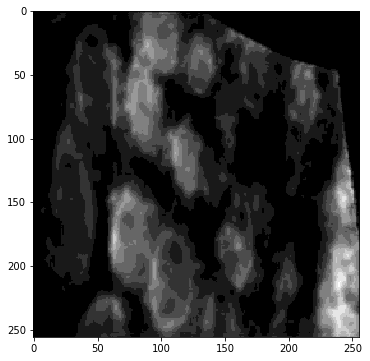

In [65]:
plt.imshow(image, cmap='gray')
